# Main Script Airline Dataset

First all required packages are loaded.

Note, that only well known packages are used and all functions, methods or procedures applied are well described on the websited of the respective packages.

For this script to run, following files are required. All files are provided and can also be recreated using the data script.

- 'DataFrame'
- 'clean_data'
- 'adjacency_matrix.csv'
- 'test.csv'


In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


The normalization function for scaling the data within the range between 1 - 5 is defined below

In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

The following function is the L2-normalization applied in the GraphSage model

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Load and Inspect the Data

Below a general overview of the dataset is gained.

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
# Adjust coding of Class, such that range is from 1-3. Was 0-2 before for the MAG generation process
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0          1              0   69               0      1              964   
1          0              0   55               1      3              240   
2          1              0   51               1      3             2672   
3          0              1   27               1      1              495   
4          0              0   12               0      1              462   
...      ...            ...  ...             ...    ...              ...   
5995       1              0   49               0      1             1587   
5996       1              0   33               0      1              588   
5997       0              0   50               0      1             2358   
5998       0              0   35               0      1              672   
5999       0              0   32               0      3              397   

      Inflight wifi service  Departure/Arrival time convenient  \
0                         3                                  2   
1                         2                                  5   
2                         5                                  5   
3                         2                                  3   
4                         2                                  4   
...                     ...                                ...   
5995                      3                                  4   
5996                      2                                  5   
5997                      1                                  4   
5998                      2                                  3   
5999                      3                                  4   

      Ease of Online booking  Gate location  ...  Seat comfort  \
0                          3              3  ...             2   
1                          5              5  ...             2   
2                          5              5  ...             1   
3                          2              2  ...             3   
4                          2              3  ...             2   
...                      ...            ...  ...           ...   
5995                       3              4  ...             5   
5996                       2              3  ...             5   
5997                       1              5  ...             4   
5998                       2              2  ...             5   
5999                       3              1  ...             4   

      Inflight entertainment  On-board service  Leg room service  \
0                          5                 5                 3   
1                          1                 1                 2   
2                          4                 4                 4   
3                          3                 4                 4   
4                          2                 3                 4   
...                      ...               ...               ...   
5995                       4                 4                 3   
5996                       5                 5                 3   
5997                       4                 4                 5   
5998                       5                 1                 1   
5999                       4                 4                 2   

      Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                    5                1                 5            3   
1                    3                2                 3            2   
2                    4                5                 4            3   
3                    3                4                 2            3   
4                    2                2                 1            2   
...                ...              ...               ...          ...   
5995                 5                3                 4            5   
5996                 5                5                 5            5   
5997                 4  

In [7]:
# Distribution of Gender in the data
X.Gender.value_counts(normalize=True)

1    0.507667
0    0.492333
Name: Gender, dtype: float64

<Figure size 2160x2160 with 0 Axes>

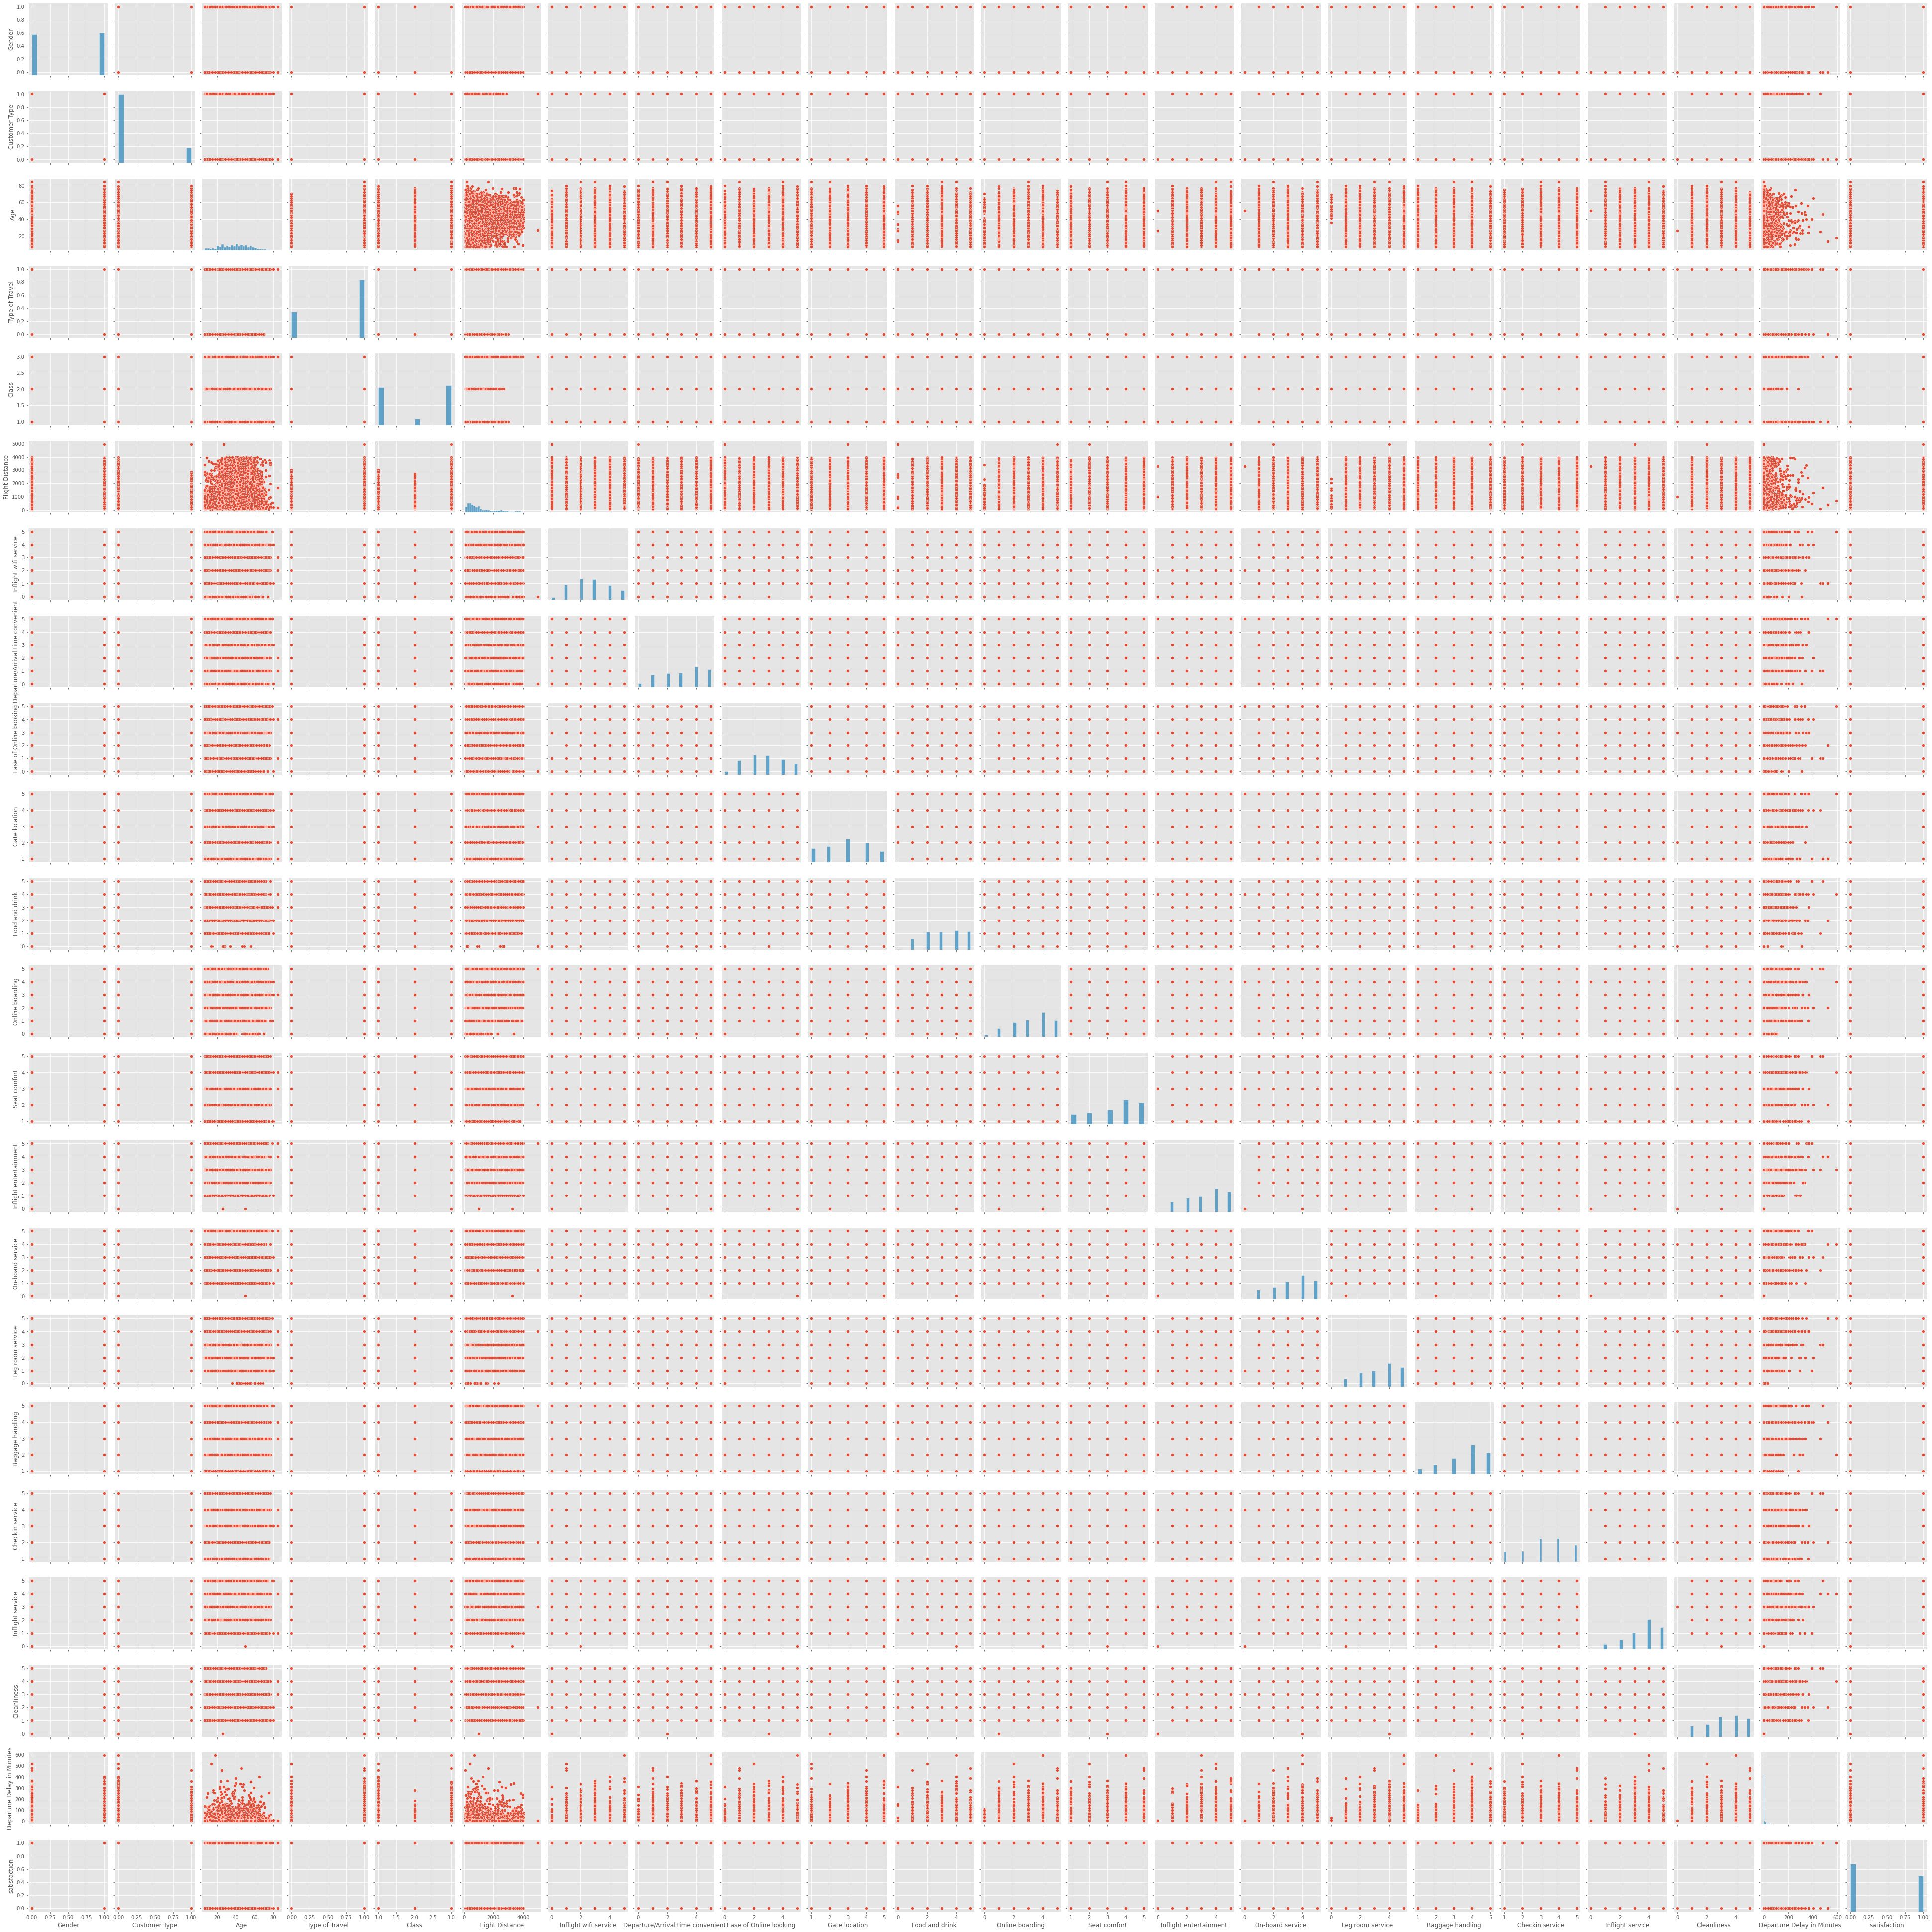

In [8]:
# Pairplot of ht entire dataset
plt.figure(figsize=(30,30))
sns.pairplot(X)
plt.show()

In [9]:
# Can be used to investigate the value counts for every category given the typ of travel
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [10]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

## Load the Graph Generated in The Data Script

In [11]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [12]:
np.diag(A).sum()

0.0

In [13]:
G = nx.from_numpy_matrix(A)

In [14]:
nx.is_connected(G)

True

## Dummy Code and Normalize the Data

In [15]:
features = pd.Series(X.satisfaction) # separate label from features
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load and Pre-Process the Test Data in the exact same way as the Training Data

In [16]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [17]:
TEST = df_test.copy(deep=True)

In [18]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [19]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [20]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

## Plot the Training- Validation Graph

In [21]:
pos = nx.spring_layout(G)

In [22]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

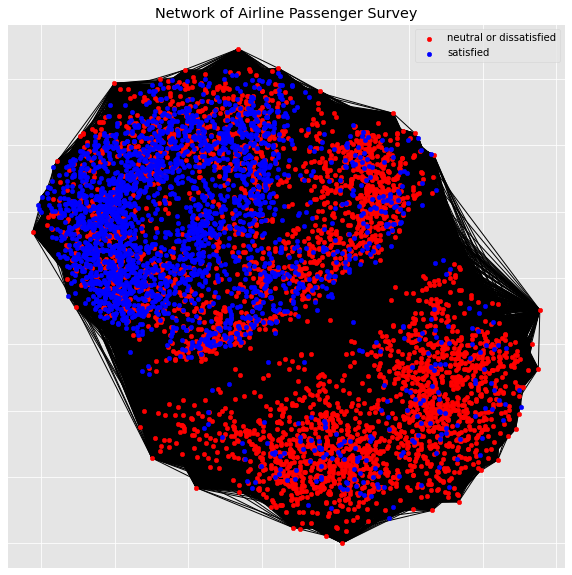

In [23]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
nx.draw_networkx_edges(G,pos,label=None)
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

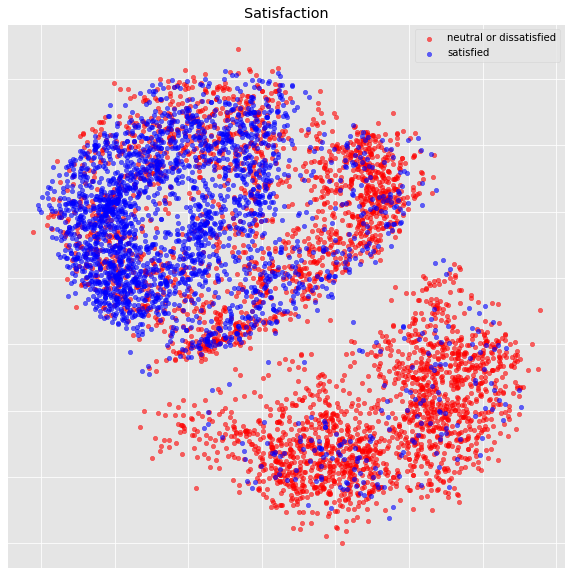

In [24]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

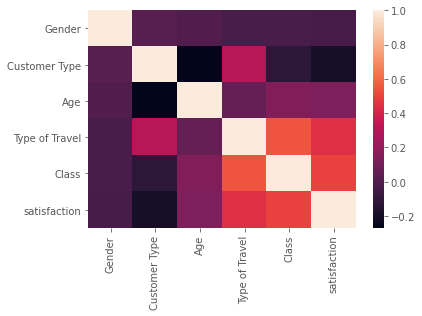

In [25]:
# correlation Map of the Attribute Variables and the Label
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [26]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

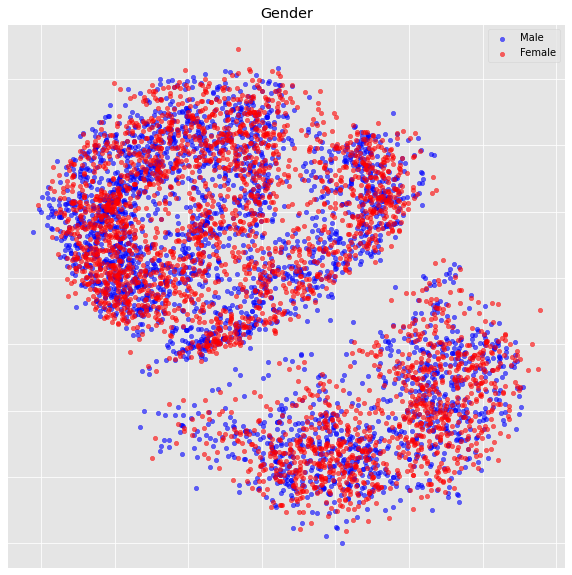

In [27]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [28]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

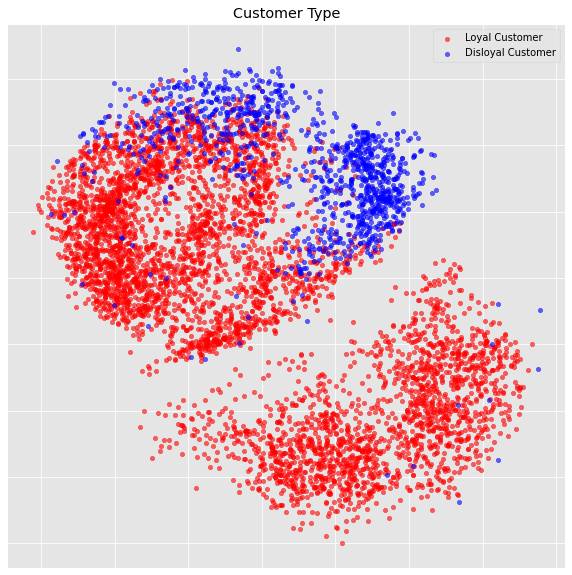

In [29]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [30]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

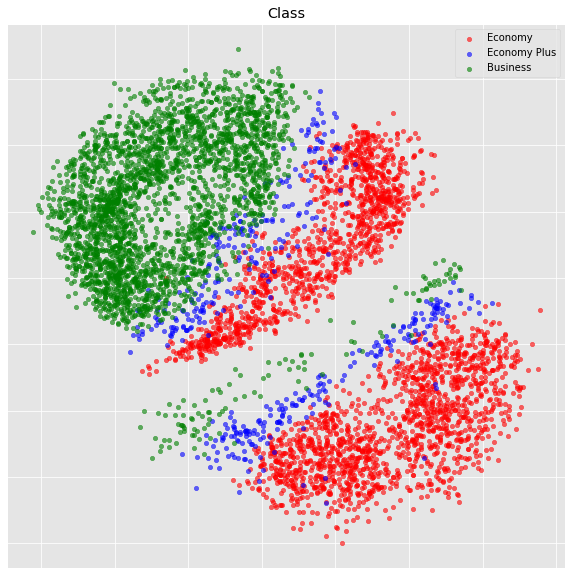

In [31]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [32]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

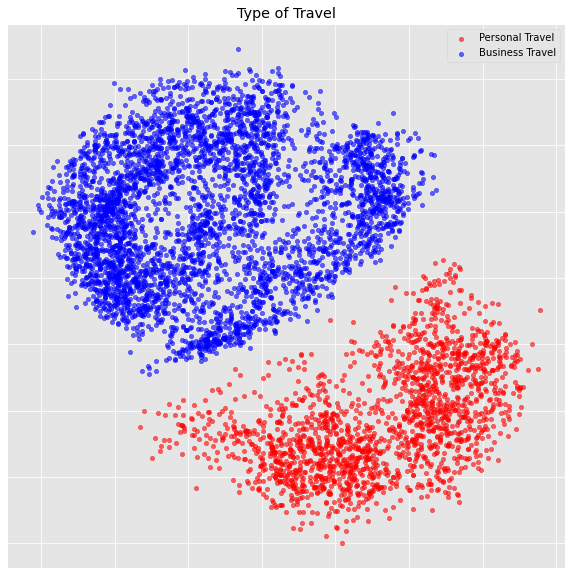

In [33]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [34]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [35]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

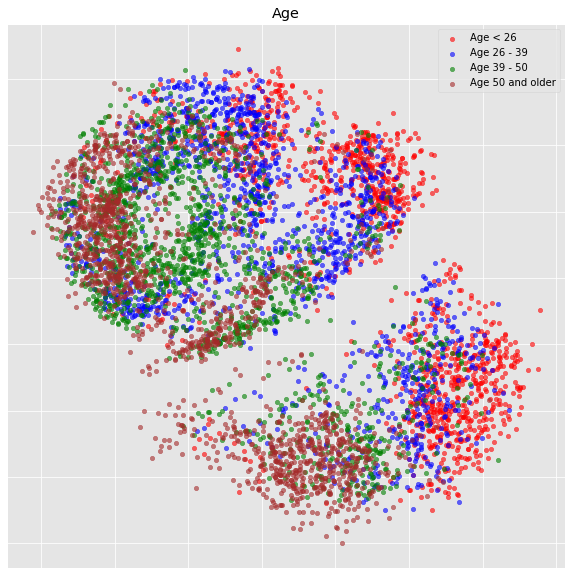

In [36]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

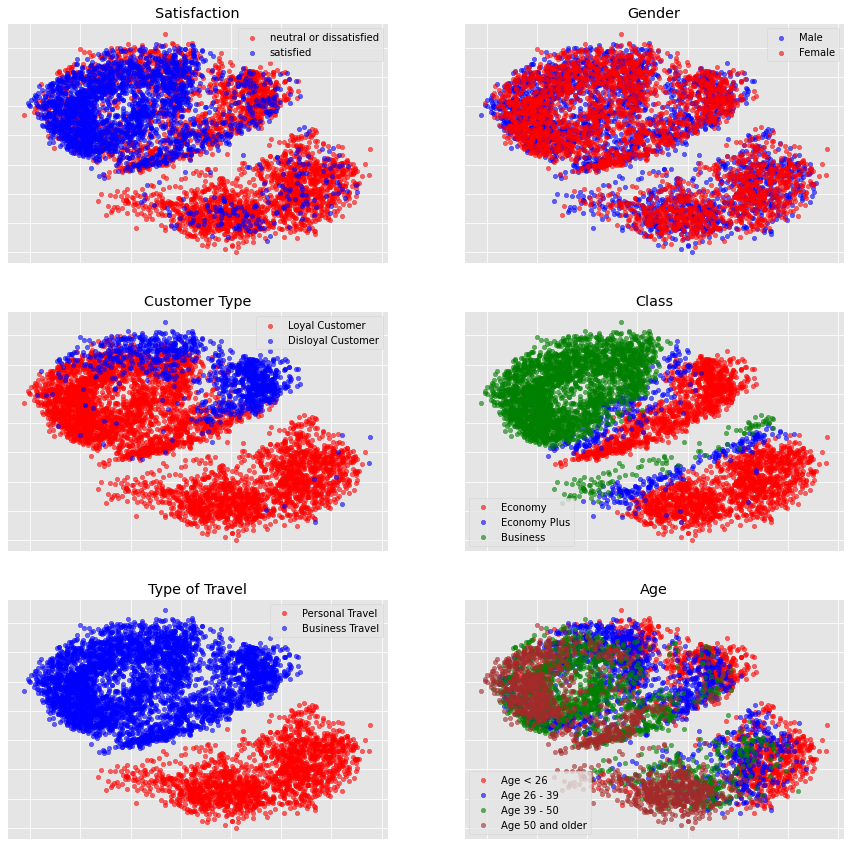

In [37]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


## Assign the Graph Data to a dgl Graph and Prepare the Data for Machine Learning

In [38]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [39]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [40]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [41]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [42]:
len(train_nids)

4809

In [43]:
len(valid_nids)

1191

## Define the Dataloaders

In [44]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [45]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([ 572, 1567,  144,  ..., 5958, 1922, 4151]), tensor([ 572, 1567,  144, 4564,  651, 2255,   99,  177, 3417, 3880, 4939, 5168,
        2954, 1313, 4974, 2341, 5010, 4614, 5500, 3073,  584, 2854, 1422, 5143,
        2004, 5169, 5764, 2772,  620, 4014,  549, 3904, 2933,  797, 4111, 2054,
         232,  153, 5024, 1914,  716, 5051, 2617, 3331, 1939, 3627, 3913, 5507,
        4550, 5215]), [Block(num_src_nodes=2465, num_dst_nodes=528, num_edges=2640), Block(num_src_nodes=528, num_dst_nodes=50, num_edges=500)]]


In [46]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2465 nodes' input features


In [47]:
print(bipartites)

[Block(num_src_nodes=2465, num_dst_nodes=528, num_edges=2640), Block(num_src_nodes=528, num_dst_nodes=50, num_edges=500)]


In [48]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Define the GraphSage Model, Train and get Results

The aggregation types are named as follows:

- 'pool' = max-pooling
- 'mean' = mean aggregations
- 'lstm' = LSTM aggregation

For sum-pooling, the class SumSage is used where 'pool' refers to sum-pooling and makes used of the script in the file sage.py

Note, that the logSoftmax function is not defined in the Sage classes below for the final output layer. This is because, the logSoftmax function is automatically applied when calculating the loss using the F.cross_entropy function. For that reason, the logSoftmax function is applied separately in the training script for getting the predicted values. This is both true for the GraphSage and GCN models.

In [49]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [50]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [51]:
# choose between sumSage or the standard GraphSage models and define the optimizer

#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='pool') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)#deine optimizer

Below the GraphSage model is trained

In [52]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.627, Training Loss: 0.637
Epoch: 0, Validation Accuracy: 0.798, Validation Loss: 0.532, Time: 2.7186
Epoch: 1, Training Accuracy: 0.817, Training Loss: 0.451
Epoch: 1, Validation Accuracy: 0.821, Validation Loss: 0.413, Time: 2.2970
Epoch: 2, Training Accuracy: 0.844, Training Loss: 0.391
Epoch: 2, Validation Accuracy: 0.831, Validation Loss: 0.393, Time: 2.0975
Epoch: 3, Training Accuracy: 0.847, Training Loss: 0.376
Epoch: 3, Validation Accuracy: 0.859, Validation Loss: 0.364, Time: 2.0982
Epoch: 4, Training Accuracy: 0.855, Training Loss: 0.365
Epoch: 4, Validation Accuracy: 0.832, Validation Loss: 0.373, Time: 2.1020
Epoch: 5, Training Accuracy: 0.864, Training Loss: 0.344
Epoch: 5, Validation Accuracy: 0.850, Validation Loss: 0.355, Time: 2.0399
Epoch: 6, Training Accuracy: 0.864, Training Loss: 0.342
Epoch: 6, Validation Accuracy: 0.860, Validation Loss: 0.338, Time: 1.9759
Epoch: 7, Training Accuracy: 0.872, Training Loss: 0.329
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.936, Training Loss: 0.168
Epoch: 62, Validation Accuracy: 0.945, Validation Loss: 0.163, Time: 1.7528
Epoch: 63, Training Accuracy: 0.931, Training Loss: 0.176
Epoch: 63, Validation Accuracy: 0.943, Validation Loss: 0.166, Time: 1.7534
Epoch: 64, Training Accuracy: 0.936, Training Loss: 0.166
Epoch: 64, Validation Accuracy: 0.916, Validation Loss: 0.216, Time: 1.7504
Epoch: 65, Training Accuracy: 0.925, Training Loss: 0.182
Epoch: 65, Validation Accuracy: 0.943, Validation Loss: 0.166, Time: 1.7501
Epoch: 66, Training Accuracy: 0.935, Training Loss: 0.164
Epoch: 66, Validation Accuracy: 0.942, Validation Loss: 0.160, Time: 1.7497
Epoch: 67, Training Accuracy: 0.941, Training Loss: 0.164
Epoch: 67, Validation Accuracy: 0.935, Validation Loss: 0.185, Time: 1.7504
Epoch: 68, Training Accuracy: 0.934, Training Loss: 0.170
Epoch: 68, Validation Accuracy: 0.940, Validation Loss: 0.167, Time: 1.7487
Epoch: 69, Training Accuracy: 0.936, Training Loss: 0.173
Epoc

Epoch: 123, Training Accuracy: 0.944, Training Loss: 0.141
Epoch: 123, Validation Accuracy: 0.945, Validation Loss: 0.152, Time: 1.6925
Epoch: 124, Training Accuracy: 0.943, Training Loss: 0.149
Epoch: 124, Validation Accuracy: 0.948, Validation Loss: 0.143, Time: 1.6899
Epoch: 125, Training Accuracy: 0.942, Training Loss: 0.147
Epoch: 125, Validation Accuracy: 0.945, Validation Loss: 0.147, Time: 1.6879
Epoch: 126, Training Accuracy: 0.945, Training Loss: 0.145
Epoch: 126, Validation Accuracy: 0.947, Validation Loss: 0.142, Time: 1.6884
Epoch: 127, Training Accuracy: 0.939, Training Loss: 0.146
Epoch: 127, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.6905
Epoch: 128, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 128, Validation Accuracy: 0.945, Validation Loss: 0.148, Time: 1.6943
Epoch: 129, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 129, Validation Accuracy: 0.941, Validation Loss: 0.149, Time: 1.6950
Epoch: 130, Training Accuracy: 0.943, Training L

Epoch: 184, Training Accuracy: 0.944, Training Loss: 0.139
Epoch: 184, Validation Accuracy: 0.930, Validation Loss: 0.172, Time: 1.7388
Epoch: 185, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 185, Validation Accuracy: 0.940, Validation Loss: 0.137, Time: 1.7461
Epoch: 186, Training Accuracy: 0.947, Training Loss: 0.139
Epoch: 186, Validation Accuracy: 0.940, Validation Loss: 0.145, Time: 1.7554
Epoch: 187, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 187, Validation Accuracy: 0.949, Validation Loss: 0.145, Time: 1.7612
Epoch: 188, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 188, Validation Accuracy: 0.945, Validation Loss: 0.141, Time: 1.7600
Epoch: 189, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 189, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.7571
Epoch: 190, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 190, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.7544
Epoch: 191, Training Accuracy: 0.950, Training L

Epoch: 245, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 245, Validation Accuracy: 0.950, Validation Loss: 0.139, Time: 1.7302
Epoch: 246, Training Accuracy: 0.949, Training Loss: 0.130
Epoch: 246, Validation Accuracy: 0.951, Validation Loss: 0.130, Time: 1.7304
Epoch: 247, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 247, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.7310
Epoch: 248, Training Accuracy: 0.945, Training Loss: 0.138
Epoch: 248, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.7315
Epoch: 249, Training Accuracy: 0.944, Training Loss: 0.131
Epoch: 249, Validation Accuracy: 0.945, Validation Loss: 0.147, Time: 1.7317
Epoch: 250, Training Accuracy: 0.943, Training Loss: 0.142
Epoch: 250, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.7312
Epoch: 251, Training Accuracy: 0.952, Training Loss: 0.121
Epoch: 251, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.7302
Epoch: 252, Training Accuracy: 0.944, Training L

Epoch: 306, Training Accuracy: 0.947, Training Loss: 0.133
Epoch: 306, Validation Accuracy: 0.945, Validation Loss: 0.139, Time: 1.7480
Epoch: 307, Training Accuracy: 0.953, Training Loss: 0.126
Epoch: 307, Validation Accuracy: 0.950, Validation Loss: 0.143, Time: 1.7486
Epoch: 308, Training Accuracy: 0.955, Training Loss: 0.120
Epoch: 308, Validation Accuracy: 0.951, Validation Loss: 0.137, Time: 1.7486
Epoch: 309, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 309, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.7482
Epoch: 310, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 310, Validation Accuracy: 0.946, Validation Loss: 0.146, Time: 1.7489
Epoch: 311, Training Accuracy: 0.949, Training Loss: 0.129
Epoch: 311, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.7508
Epoch: 312, Training Accuracy: 0.950, Training Loss: 0.122
Epoch: 312, Validation Accuracy: 0.948, Validation Loss: 0.134, Time: 1.7530
Epoch: 313, Training Accuracy: 0.950, Training L

Epoch: 367, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 367, Validation Accuracy: 0.950, Validation Loss: 0.132, Time: 1.7772
Epoch: 368, Training Accuracy: 0.951, Training Loss: 0.119
Epoch: 368, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.7766
Epoch: 369, Training Accuracy: 0.952, Training Loss: 0.124
Epoch: 369, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.7774
Epoch: 370, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 370, Validation Accuracy: 0.937, Validation Loss: 0.162, Time: 1.7766
Epoch: 371, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 371, Validation Accuracy: 0.929, Validation Loss: 0.166, Time: 1.7758
Epoch: 372, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 372, Validation Accuracy: 0.944, Validation Loss: 0.143, Time: 1.7763
Epoch: 373, Training Accuracy: 0.949, Training Loss: 0.124
Epoch: 373, Validation Accuracy: 0.948, Validation Loss: 0.131, Time: 1.7755
Epoch: 374, Training Accuracy: 0.953, Training L

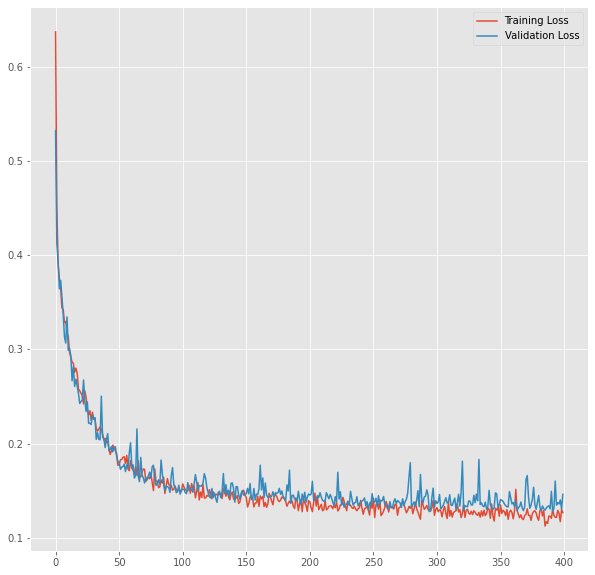

In [53]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

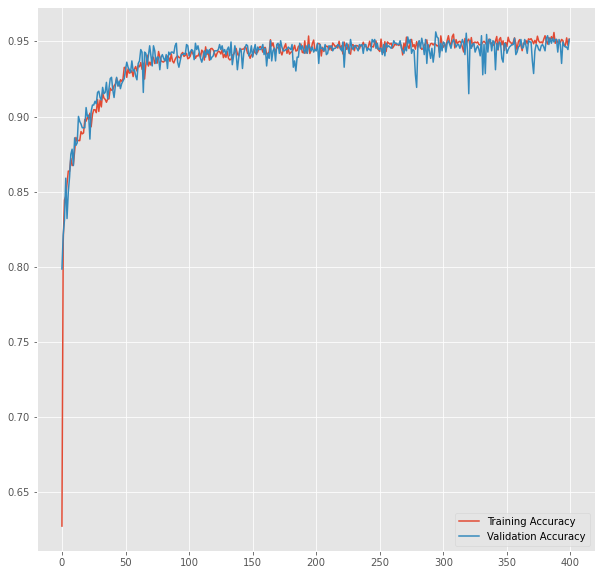

In [54]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [55]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9515463917525772
Validation Accuracy: 0.9513014273719563


In [56]:
np.argmax(valid_acc)

294

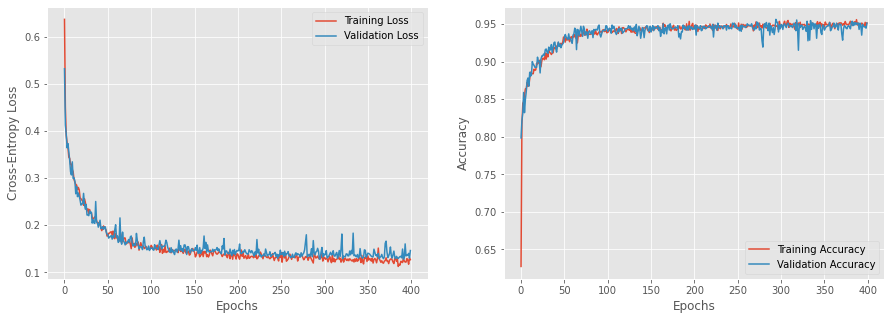

In [57]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# shows the model parameters of the GraphSage model
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

## Graph Convolutional Network

Below the dgl data is reset to 30% training and 70 validation data which is then used for the GCN.

In [59]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

Define the GCN network

In [60]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=None)
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

Compile the model

In [61]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [62]:
def evaluate(model_gcn, graph, features, labels, mask):
    model_gcn.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train the model

In [63]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model_gcn.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 0.7724, validation loss: 0.7744, training accuracy: 0.4318, validation accuracy: 0.4286, Time: 0.6968
Epoch: 10, train loss: 0.7018, validation loss: 0.7022, training accuracy: 0.4318, validation accuracy: 0.4286, Time: 0.3794
Epoch: 20, train loss: 0.6798, validation loss: 0.6791, training accuracy: 0.5682, validation accuracy: 0.5714, Time: 0.3905
Epoch: 30, train loss: 0.6672, validation loss: 0.6667, training accuracy: 0.5682, validation accuracy: 0.5714, Time: 0.4701
Epoch: 40, train loss: 0.6527, validation loss: 0.6529, training accuracy: 0.5682, validation accuracy: 0.5714, Time: 0.4845
Epoch: 50, train loss: 0.6391, validation loss: 0.6396, training accuracy: 0.7697, validation accuracy: 0.7682, Time: 0.4938
Epoch: 60, train loss: 0.6250, validation loss: 0.6259, training accuracy: 0.7640, validation accuracy: 0.7671, Time: 0.4788
Epoch: 70, train loss: 0.6110, validation loss: 0.6122, training accuracy: 0.7588, validation accuracy: 0.7664, Time: 0.4808
E

Epoch: 660, train loss: 0.4927, validation loss: 0.4949, training accuracy: 0.7628, validation accuracy: 0.7661, Time: 0.3369
Epoch: 670, train loss: 0.4924, validation loss: 0.4946, training accuracy: 0.7628, validation accuracy: 0.7668, Time: 0.3359
Epoch: 680, train loss: 0.4923, validation loss: 0.4944, training accuracy: 0.7628, validation accuracy: 0.7675, Time: 0.3356
Epoch: 690, train loss: 0.4921, validation loss: 0.4942, training accuracy: 0.7628, validation accuracy: 0.7664, Time: 0.3362
Epoch: 700, train loss: 0.4920, validation loss: 0.4941, training accuracy: 0.7628, validation accuracy: 0.7673, Time: 0.3357
Epoch: 710, train loss: 0.4918, validation loss: 0.4939, training accuracy: 0.7628, validation accuracy: 0.7668, Time: 0.3349
Epoch: 720, train loss: 0.4917, validation loss: 0.4938, training accuracy: 0.7628, validation accuracy: 0.7664, Time: 0.3341
Epoch: 730, train loss: 0.4918, validation loss: 0.4938, training accuracy: 0.7645, validation accuracy: 0.7657, Time:

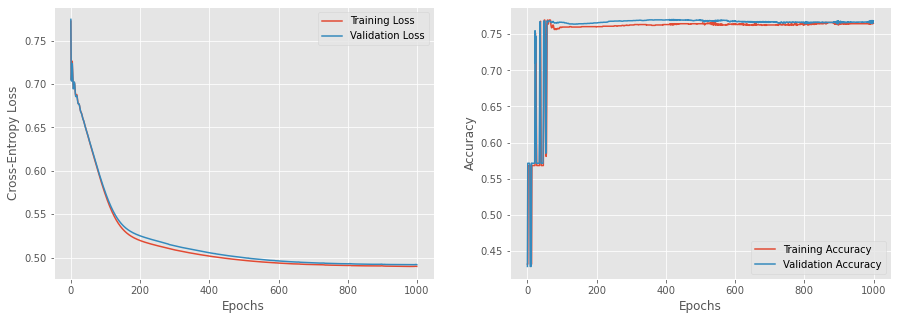

In [64]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [65]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.7654234107436078
-------------------------------------------------------------
Classification Accuracy training set 0.7651122625215889
-------------------------------------------------------------
Confusion Matrix validation set:
[[1861  575]
 [ 425 1402]]
-------------------------------------------------------------
Confusion Matrix training set:
[[761 226]
 [182 568]]


In [66]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(in=24, out=2, normalization=both, activation=None)
)>

## Generate Test Graph

Based on the test data, a new test graph is generated. This is the same procedure as is done in the the data script. It is repeated here for the test graph so that every A-Z simulation contains a new test graph. This ensures, that there is not some graph sampling bias. Note, different training graphs were tested as well. The results are consistent regardless of the generated graph.

In [67]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [68]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [69]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [70]:
A = A + A.T

In [71]:
G_test = nx.from_numpy_matrix(A)

In [72]:
test_features = pd.Series(TEST.satisfaction)

## Assign the data to a dgl graph

In [73]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [74]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define the inference function to get the test graph results

In [75]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

## Get the test graph results

In [76]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


In [77]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9401666666666667


In [78]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9401666666666667
-------------------------------------------------------------
Confusion Matrix test set:
[[3222  181]
 [ 178 2419]]


In [79]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9401666666666667

In [80]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.1524509, dtype=float32)

In [81]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

## ANN Simulations

The following code was used to simulated the consistency of ANN results. This was done to compare the ANN results with the GNN results.

In [82]:
f = pd.get_dummies(features)
yy_test = pd.get_dummies(yy)


model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

def sim_ann(model,opt,f,x_wd,xx_dummy,yy_test):
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

        x_train_tf = tf.convert_to_tensor(x_train)
        x_test_tf = tf.convert_to_tensor(x_test)
        y_train_tf = tf.convert_to_tensor(y_train)
        y_test_tf = tf.convert_to_tensor(y_test)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)
        
        train_loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        train_acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        
        results = model.evaluate(xx_dummy, yy_test, batch_size=128)
        test_loss.append(results[0])
        test_acc.append(results[1])
        print("test loss, test acc:", results)
    
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
        
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = sim_ann(model,opt,f,x_wd,xx_dummy,yy_test)
        
    

Epoch 1/400
96/96 [==============================] - 3s 22ms/step - loss: 1.0845 - accuracy: 0.5570 - val_loss: 0.5255 - val_accuracy: 0.7408
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.5805 - accuracy: 0.7522 - val_loss: 0.4057 - val_accuracy: 0.8300
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4701 - accuracy: 0.8301 - val_loss: 0.3403 - val_accuracy: 0.8608
Epoch 4/400
96/96 [==============================] - 0s 5ms/step - loss: 0.4366 - accuracy: 0.8401 - val_loss: 0.3276 - val_accuracy: 0.8758
Epoch 5/400
96/96 [==============================] - 1s 6ms/step - loss: 0.3971 - accuracy: 0.8620 - val_loss: 0.2960 - val_accuracy: 0.8858
Epoch 6/400
96/96 [==============================] - 0s 5ms/step - loss: 0.4007 - accuracy: 0.8729 - val_loss: 0.2723 - val_accuracy: 0.8883
Epoch 7/400
96/96 [==============================] - 0s 4ms/step - loss: 0.3664 - accuracy: 0.8783 - val_loss: 0.2588 - val_accuracy: 0.8942
Epoch 8/400


Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2281 - accuracy: 0.9292 - val_loss: 0.2054 - val_accuracy: 0.9167
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2501 - accuracy: 0.9189 - val_loss: 0.1899 - val_accuracy: 0.9258
Epoch 61/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.9180 - val_loss: 0.1896 - val_accuracy: 0.9225
Epoch 62/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2430 - accuracy: 0.9252 - val_loss: 0.2026 - val_accuracy: 0.9167
Epoch 63/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2429 - accuracy: 0.9235 - val_loss: 0.3613 - val_accuracy: 0.8533
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3396 - accuracy: 0.8864 - val_loss: 0.1970 - val_accuracy: 0.9167
Epoch 65/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2286 - accuracy: 0.9276 - val_loss: 0.1898 - val_accuracy: 0.9292
Epoch 

96/96 [==============================] - 1s 5ms/step - loss: 0.2740 - accuracy: 0.9222 - val_loss: 0.1902 - val_accuracy: 0.9275
Epoch 117/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2459 - accuracy: 0.9274 - val_loss: 0.1853 - val_accuracy: 0.9275
Epoch 118/400
96/96 [==============================] - 1s 6ms/step - loss: 0.2538 - accuracy: 0.9270 - val_loss: 0.1892 - val_accuracy: 0.9258
Epoch 119/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2362 - accuracy: 0.9289 - val_loss: 0.1853 - val_accuracy: 0.9300
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2487 - accuracy: 0.9204 - val_loss: 0.2452 - val_accuracy: 0.9025
Epoch 121/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2853 - accuracy: 0.9097 - val_loss: 0.1993 - val_accuracy: 0.9300
Epoch 122/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2380 - accuracy: 0.9231 - val_loss: 0.1936 - val_accuracy: 0.9325
Epoch 123/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.9382 - val_loss: 0.1794 - val_accuracy: 0.9250
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9282 - val_loss: 0.1873 - val_accuracy: 0.9242
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2365 - accuracy: 0.9286 - val_loss: 0.1786 - val_accuracy: 0.9275
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2160 - accuracy: 0.9324 - val_loss: 0.1769 - val_accuracy: 0.9300
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1977 - accuracy: 0.9334 - val_loss: 0.1768 - val_accuracy: 0.9300
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2329 - accuracy: 0.9405 - val_loss: 0.1737 - val_accuracy: 0.9350
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.9397 - val_loss: 0.1772 - val_accuracy: 0.9317
Epoch 180/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1927 - accuracy: 0.9394 - val_loss: 0.1728 - val_accuracy: 0.9342
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.9320 - val_loss: 0.1761 - val_accuracy: 0.9325
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2154 - accuracy: 0.9330 - val_loss: 0.2182 - val_accuracy: 0.9108
Epoch 233/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2767 - accuracy: 0.9174 - val_loss: 0.1983 - val_accuracy: 0.9217
Epoch 234/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2297 - accuracy: 0.9338 - val_loss: 0.2010 - val_accuracy: 0.9217
Epoch 235/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2665 - accuracy: 0.9308 - val_loss: 0.1817 - val_accuracy: 0.9333
Epoch 236/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2455 - accuracy: 0.9287 - val_loss: 0.1808 - val_accuracy: 0.9317
Epoch 237/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.9383 - val_loss: 0.1706 - val_accuracy: 0.9350
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2127 - accuracy: 0.9343 - val_loss: 0.1688 - val_accuracy: 0.9350
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2360 - accuracy: 0.9391 - val_loss: 0.1729 - val_accuracy: 0.9292
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2259 - accuracy: 0.9390 - val_loss: 0.1725 - val_accuracy: 0.9350
Epoch 291/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2016 - accuracy: 0.9381 - val_loss: 0.1706 - val_accuracy: 0.9325
Epoch 292/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.9430 - val_loss: 0.1722 - val_accuracy: 0.9317
Epoch 293/400
96/96 [==============================] - 1s 6ms/step - loss: 0.2082 - accuracy: 0.9383 - val_loss: 0.1736 - val_accuracy: 0.9283
Epoch 294/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1827 - accuracy: 0.9419 - val_loss: 0.1730 - val_accuracy: 0.9342
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2157 - accuracy: 0.9388 - val_loss: 0.1736 - val_accuracy: 0.9308
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2121 - accuracy: 0.9395 - val_loss: 0.1685 - val_accuracy: 0.9325
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2308 - accuracy: 0.9383 - val_loss: 0.1668 - val_accuracy: 0.9375
Epoch 348/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2104 - accuracy: 0.9369 - val_loss: 0.1932 - val_accuracy: 0.9167
Epoch 349/400
96/96 [==============================] - 0s 3ms/step - loss: 0.6002 - accuracy: 0.8793 - val_loss: 0.1905 - val_accuracy: 0.9275
Epoch 350/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2053 - accuracy: 0.9395 - val_loss: 0.1772 - val_accuracy: 0.9342
Epoch 351/400

47/47 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9280
test loss, test acc: [0.17387154698371887, 0.9279999732971191]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2380 - accuracy: 0.9333 - val_loss: 0.1362 - val_accuracy: 0.9442
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2453 - accuracy: 0.9357 - val_loss: 0.1311 - val_accuracy: 0.9433
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2456 - accuracy: 0.9329 - val_loss: 0.1360 - val_accuracy: 0.9442
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2302 - accuracy: 0.9355 - val_loss: 0.1321 - val_accuracy: 0.9442
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9379 - val_loss: 0.1405 - val_accuracy: 0.9400
Epoch 6/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2079 - accuracy: 0.9408 - val_loss: 0.1387 - val_accuracy: 0.9400
Epoc

Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2322 - accuracy: 0.9375 - val_loss: 0.1521 - val_accuracy: 0.9358
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2021 - accuracy: 0.9414 - val_loss: 0.1511 - val_accuracy: 0.9408
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2294 - accuracy: 0.9388 - val_loss: 0.1509 - val_accuracy: 0.9425
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2011 - accuracy: 0.9368 - val_loss: 0.1519 - val_accuracy: 0.9400
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2220 - accuracy: 0.9409 - val_loss: 0.1500 - val_accuracy: 0.9433
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.9371 - val_loss: 0.1473 - val_accuracy: 0.9450
Epoch 64/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2319 - accuracy: 0.9400 - val_loss: 0.1512 - val_accuracy: 0.9383
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.9344 - val_loss: 0.1494 - val_accuracy: 0.9367
Epoch 116/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2295 - accuracy: 0.9334 - val_loss: 0.1506 - val_accuracy: 0.9417
Epoch 117/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2060 - accuracy: 0.9425 - val_loss: 0.1526 - val_accuracy: 0.9417
Epoch 118/400
96/96 [==============================] - 1s 6ms/step - loss: 0.2157 - accuracy: 0.9322 - val_loss: 0.1528 - val_accuracy: 0.9308
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2265 - accuracy: 0.9355 - val_loss: 0.1548 - val_accuracy: 0.9317
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2249 - accuracy: 0.9382 - val_loss: 0.1508 - val_accuracy: 0.9342
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.9407 - val_loss: 0.1549 - val_accuracy: 0.9367
Epoch 122/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2289 - accuracy: 0.9298 - val_loss: 0.1653 - val_accuracy: 0.9308
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2198 - accuracy: 0.9341 - val_loss: 0.1628 - val_accuracy: 0.9308
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.9197 - val_loss: 0.1631 - val_accuracy: 0.9317
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2459 - accuracy: 0.9320 - val_loss: 0.1614 - val_accuracy: 0.9375
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2541 - accuracy: 0.9229 - val_loss: 0.1595 - val_accuracy: 0.9325
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.9305 - val_loss: 0.1601 - val_accuracy: 0.9317
Epoch 178/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.9367 - val_loss: 0.1576 - val_accuracy: 0.9300
Epoch 179/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9370 - val_loss: 0.1551 - val_accuracy: 0.9383
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9398 - val_loss: 0.1574 - val_accuracy: 0.9367
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2122 - accuracy: 0.9364 - val_loss: 0.1527 - val_accuracy: 0.9375
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9478 - val_loss: 0.1643 - val_accuracy: 0.9375
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2109 - accuracy: 0.9434 - val_loss: 0.1530 - val_accuracy: 0.9375
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2247 - accuracy: 0.9281 - val_loss: 0.1521 - val_accuracy: 0.9367
Epoch 235/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2100 - accuracy: 0.9353 - val_loss: 0.1593 - val_accuracy: 0.9342
Epoch 236/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2251 - accuracy: 0.9306 - val_loss: 0.1527 - val_accuracy: 0.9367
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1959 - accuracy: 0.9433 - val_loss: 0.1531 - val_accuracy: 0.9367
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9375 - val_loss: 0.1549 - val_accuracy: 0.9350
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2040 - accuracy: 0.9344 - val_loss: 0.1524 - val_accuracy: 0.9350
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2476 - accuracy: 0.9334 - val_loss: 0.3259 - val_accuracy: 0.8725
Epoch 291/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2568 - accuracy: 0.9265 - val_loss: 0.1597 - val_accuracy: 0.9333
Epoch 292/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1931 - accuracy: 0.9386 - val_loss: 0.1907 - val_accuracy: 0.9183
Epoch 293/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2145 - accuracy: 0.9457 - val_loss: 0.1574 - val_accuracy: 0.9383
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1993 - accuracy: 0.9450 - val_loss: 0.1583 - val_accuracy: 0.9342
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2091 - accuracy: 0.9391 - val_loss: 0.1624 - val_accuracy: 0.9300
Epoch 346/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2059 - accuracy: 0.9440 - val_loss: 0.1590 - val_accuracy: 0.9367
Epoch 347/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2211 - accuracy: 0.9358 - val_loss: 0.1587 - val_accuracy: 0.9308
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1798 - accuracy: 0.9512 - val_loss: 0.1605 - val_accuracy: 0.9308
Epoch 349/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9440 - val_loss: 0.1562 - val_accuracy: 0.9375
Epoch 350/400

47/47 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.9260
test loss, test acc: [0.17710430920124054, 0.9259999990463257]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.2021 - accuracy: 0.9443 - val_loss: 0.1341 - val_accuracy: 0.9467
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2310 - accuracy: 0.9419 - val_loss: 0.1485 - val_accuracy: 0.9425
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2104 - accuracy: 0.9362 - val_loss: 0.1457 - val_accuracy: 0.9483
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2270 - accuracy: 0.9386 - val_loss: 0.1343 - val_accuracy: 0.9425
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1938 - accuracy: 0.9420 - val_loss: 0.1379 - val_accuracy: 0.9442
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.9437 - val_loss: 0.1376 - val_accuracy: 0.9450
Epoc

Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2313 - accuracy: 0.9346 - val_loss: 0.1442 - val_accuracy: 0.9450
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2021 - accuracy: 0.9386 - val_loss: 0.1448 - val_accuracy: 0.9425
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2239 - accuracy: 0.9360 - val_loss: 0.1426 - val_accuracy: 0.9458
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2232 - accuracy: 0.9346 - val_loss: 0.1572 - val_accuracy: 0.9392
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.9387 - val_loss: 0.1457 - val_accuracy: 0.9442
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2088 - accuracy: 0.9412 - val_loss: 0.1543 - val_accuracy: 0.9417
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2469 - accuracy: 0.9262 - val_loss: 0.1528 - val_accuracy: 0.9367
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.2163 - accuracy: 0.9382 - val_loss: 0.1463 - val_accuracy: 0.9450
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2174 - accuracy: 0.9405 - val_loss: 0.1461 - val_accuracy: 0.9450
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2013 - accuracy: 0.9405 - val_loss: 0.1499 - val_accuracy: 0.9392
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.9279 - val_loss: 0.1642 - val_accuracy: 0.9375
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2214 - accuracy: 0.9377 - val_loss: 0.1503 - val_accuracy: 0.9417
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9425 - val_loss: 0.1493 - val_accuracy: 0.9417
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2151 - accuracy: 0.9428 - val_loss: 0.1465 - val_accuracy: 0.9425
Epoch 121/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1991 - accuracy: 0.9433 - val_loss: 0.1473 - val_accuracy: 0.9433
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.9371 - val_loss: 0.1473 - val_accuracy: 0.9433
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.9452 - val_loss: 0.1556 - val_accuracy: 0.9408
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2007 - accuracy: 0.9392 - val_loss: 0.1661 - val_accuracy: 0.9358
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.9367 - val_loss: 0.1517 - val_accuracy: 0.9433
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9407 - val_loss: 0.1488 - val_accuracy: 0.9400
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2116 - accuracy: 0.9344 - val_loss: 0.1500 - val_accuracy: 0.9417
Epoch 178/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1724 - accuracy: 0.9448 - val_loss: 0.1549 - val_accuracy: 0.9400
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.9407 - val_loss: 0.1470 - val_accuracy: 0.9433
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.9429 - val_loss: 0.1555 - val_accuracy: 0.9375
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2513 - accuracy: 0.9349 - val_loss: 0.1492 - val_accuracy: 0.9425
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2350 - accuracy: 0.9400 - val_loss: 0.1872 - val_accuracy: 0.9258
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2199 - accuracy: 0.9387 - val_loss: 0.1492 - val_accuracy: 0.9450
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9462 - val_loss: 0.1456 - val_accuracy: 0.9458
Epoch 235/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2063 - accuracy: 0.9384 - val_loss: 0.1490 - val_accuracy: 0.9425
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.9411 - val_loss: 0.1459 - val_accuracy: 0.9425
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9497 - val_loss: 0.1515 - val_accuracy: 0.9417
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.9325 - val_loss: 0.1490 - val_accuracy: 0.9425
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.9438 - val_loss: 0.1506 - val_accuracy: 0.9400
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.9463 - val_loss: 0.1454 - val_accuracy: 0.9450
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2608 - accuracy: 0.9266 - val_loss: 0.1454 - val_accuracy: 0.9442
Epoch 292/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2181 - accuracy: 0.9387 - val_loss: 0.1535 - val_accuracy: 0.9408
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.9462 - val_loss: 0.1528 - val_accuracy: 0.9425
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9488 - val_loss: 0.1511 - val_accuracy: 0.9408
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.9466 - val_loss: 0.1544 - val_accuracy: 0.9400
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9372 - val_loss: 0.1547 - val_accuracy: 0.9367
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9431 - val_loss: 0.1492 - val_accuracy: 0.9433
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1895 - accuracy: 0.9446 - val_loss: 0.1494 - val_accuracy: 0.9442
Epoch 349/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.9435 - val_loss: 0.1540 - val_accuracy: 0.9383
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.1743 - accuracy: 0.9308
test loss, test acc: [0.17427228391170502, 0.9308333396911621]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.2410 - accuracy: 0.9325 - val_loss: 0.1193 - val_accuracy: 0.9525
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.9387 - val_loss: 0.1180 - val_accuracy: 0.9508
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.9445 - val_loss: 0.1283 - val_accuracy: 0.9483
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2075 - accuracy: 0.9385 - val_loss: 0.1243 - val_accuracy: 0.9458
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.9463 - val_loss: 0.1231 - val_accuracy: 0.9433
Ep

Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2093 - accuracy: 0.9415 - val_loss: 0.1405 - val_accuracy: 0.9400
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2600 - accuracy: 0.9374 - val_loss: 0.1485 - val_accuracy: 0.9392
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1899 - accuracy: 0.9405 - val_loss: 0.2446 - val_accuracy: 0.9158
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3753 - accuracy: 0.8907 - val_loss: 0.1624 - val_accuracy: 0.9275
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2026 - accuracy: 0.9421 - val_loss: 0.1520 - val_accuracy: 0.9333
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.9416 - val_loss: 0.1497 - val_accuracy: 0.9375
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2069 - accuracy: 0.9452 - val_loss: 0.1523 - val_accuracy: 0.9350
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2031 - accuracy: 0.9450 - val_loss: 0.1462 - val_accuracy: 0.9367
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1945 - accuracy: 0.9447 - val_loss: 0.1456 - val_accuracy: 0.9358
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1705 - accuracy: 0.9450 - val_loss: 0.1457 - val_accuracy: 0.9383
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.9509 - val_loss: 0.1464 - val_accuracy: 0.9358
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9522 - val_loss: 0.1447 - val_accuracy: 0.9333
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.9492 - val_loss: 0.1448 - val_accuracy: 0.9342
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.9389 - val_loss: 0.1453 - val_accuracy: 0.9350
Epoch 120/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9437 - val_loss: 0.1476 - val_accuracy: 0.9425
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9381 - val_loss: 0.1526 - val_accuracy: 0.9400
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2512 - accuracy: 0.9311 - val_loss: 0.1495 - val_accuracy: 0.9367
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9514 - val_loss: 0.1461 - val_accuracy: 0.9350
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.9463 - val_loss: 0.1470 - val_accuracy: 0.9300
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1890 - accuracy: 0.9445 - val_loss: 0.1532 - val_accuracy: 0.9408
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9412 - val_loss: 0.1501 - val_accuracy: 0.9417
Epoch 177/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2283 - accuracy: 0.9429 - val_loss: 0.1503 - val_accuracy: 0.9392
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2002 - accuracy: 0.9450 - val_loss: 0.1468 - val_accuracy: 0.9383
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2342 - accuracy: 0.9417 - val_loss: 0.1514 - val_accuracy: 0.9392
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.9525 - val_loss: 0.1493 - val_accuracy: 0.9400
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1836 - accuracy: 0.9538 - val_loss: 0.1474 - val_accuracy: 0.9375
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.9477 - val_loss: 0.1486 - val_accuracy: 0.9375
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2175 - accuracy: 0.9434 - val_loss: 0.1542 - val_accuracy: 0.9367
Epoch 234/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.9485 - val_loss: 0.1510 - val_accuracy: 0.9342
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9509 - val_loss: 0.1564 - val_accuracy: 0.9392
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9458 - val_loss: 0.1532 - val_accuracy: 0.9408
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.9438 - val_loss: 0.1542 - val_accuracy: 0.9400
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2263 - accuracy: 0.9433 - val_loss: 0.1526 - val_accuracy: 0.9358
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.9518 - val_loss: 0.1517 - val_accuracy: 0.9267
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.9423 - val_loss: 0.1567 - val_accuracy: 0.9392
Epoch 291/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9459 - val_loss: 0.1530 - val_accuracy: 0.9342
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1871 - accuracy: 0.9512 - val_loss: 0.1539 - val_accuracy: 0.9342
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.9315 - val_loss: 0.2064 - val_accuracy: 0.9158
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2281 - accuracy: 0.9309 - val_loss: 0.1742 - val_accuracy: 0.9308
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2021 - accuracy: 0.9400 - val_loss: 0.1625 - val_accuracy: 0.9317
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9496 - val_loss: 0.1592 - val_accuracy: 0.9342
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1981 - accuracy: 0.9436 - val_loss: 0.1550 - val_accuracy: 0.9358
Epoch 348/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2211 - accuracy: 0.9443 - val_loss: 0.1607 - val_accuracy: 0.9350
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2149 - accuracy: 0.9442 - val_loss: 0.1597 - val_accuracy: 0.9325
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.1751 - accuracy: 0.9298
test loss, test acc: [0.17510809004306793, 0.9298333525657654]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.2589 - accuracy: 0.9305 - val_loss: 0.1244 - val_accuracy: 0.9550
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9410 - val_loss: 0.1386 - val_accuracy: 0.9325
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2136 - accuracy: 0.9341 - val_loss: 0.1235 - val_accuracy: 0.9550
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2212 - accuracy: 0.9388 - val_loss: 0.1263 - val_accuracy: 0.9500


Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1943 - accuracy: 0.9468 - val_loss: 0.1261 - val_accuracy: 0.9517
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2221 - accuracy: 0.9372 - val_loss: 0.1227 - val_accuracy: 0.9500
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.9462 - val_loss: 0.1229 - val_accuracy: 0.9533
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9429 - val_loss: 0.1274 - val_accuracy: 0.9475
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2438 - accuracy: 0.9358 - val_loss: 0.1286 - val_accuracy: 0.9500
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9465 - val_loss: 0.1271 - val_accuracy: 0.9533
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9470 - val_loss: 0.1223 - val_accuracy: 0.9492
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.2107 - accuracy: 0.9466 - val_loss: 0.1272 - val_accuracy: 0.9500
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1815 - accuracy: 0.9497 - val_loss: 0.1300 - val_accuracy: 0.9483
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9502 - val_loss: 0.1235 - val_accuracy: 0.9508
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2055 - accuracy: 0.9446 - val_loss: 0.1235 - val_accuracy: 0.9475
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2148 - accuracy: 0.9375 - val_loss: 0.1406 - val_accuracy: 0.9417
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1912 - accuracy: 0.9431 - val_loss: 0.1283 - val_accuracy: 0.9508
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9506 - val_loss: 0.1256 - val_accuracy: 0.9500
Epoch 119/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.9109 - val_loss: 0.1477 - val_accuracy: 0.9375
Epoch 170/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2278 - accuracy: 0.9339 - val_loss: 0.1547 - val_accuracy: 0.9350
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2390 - accuracy: 0.9263 - val_loss: 0.1408 - val_accuracy: 0.9442
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2697 - accuracy: 0.9208 - val_loss: 0.1391 - val_accuracy: 0.9450
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.9383 - val_loss: 0.1367 - val_accuracy: 0.9458
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2361 - accuracy: 0.9300 - val_loss: 0.1377 - val_accuracy: 0.9450
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2425 - accuracy: 0.9299 - val_loss: 0.1424 - val_accuracy: 0.9400
Epoch 176/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2142 - accuracy: 0.9426 - val_loss: 0.1293 - val_accuracy: 0.9433
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1950 - accuracy: 0.9462 - val_loss: 0.1315 - val_accuracy: 0.9392
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1964 - accuracy: 0.9503 - val_loss: 0.1340 - val_accuracy: 0.9400
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9529 - val_loss: 0.1318 - val_accuracy: 0.9417
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2213 - accuracy: 0.9381 - val_loss: 0.1303 - val_accuracy: 0.9417
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1828 - accuracy: 0.9475 - val_loss: 0.1307 - val_accuracy: 0.9417
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2016 - accuracy: 0.9421 - val_loss: 0.1287 - val_accuracy: 0.9417
Epoch 233/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2389 - accuracy: 0.9307 - val_loss: 0.1410 - val_accuracy: 0.9475
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.9313 - val_loss: 0.1358 - val_accuracy: 0.9450
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2401 - accuracy: 0.9335 - val_loss: 0.1469 - val_accuracy: 0.9383
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2344 - accuracy: 0.9383 - val_loss: 0.1727 - val_accuracy: 0.9350
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.9348 - val_loss: 0.1571 - val_accuracy: 0.9375
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 1.0602 - accuracy: 0.8432 - val_loss: 0.5735 - val_accuracy: 0.8750
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.7712 - accuracy: 0.8750 - val_loss: 0.3312 - val_accuracy: 0.9042
Epoch 290/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9523 - val_loss: 0.1298 - val_accuracy: 0.9408
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1661 - accuracy: 0.9568 - val_loss: 0.1306 - val_accuracy: 0.9417
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1832 - accuracy: 0.9464 - val_loss: 0.1304 - val_accuracy: 0.9433
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.9456 - val_loss: 0.1301 - val_accuracy: 0.9417
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.9455 - val_loss: 0.1307 - val_accuracy: 0.9450
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.9456 - val_loss: 0.1396 - val_accuracy: 0.9400
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.9376 - val_loss: 0.1307 - val_accuracy: 0.9408
Epoch 347/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1978 - accuracy: 0.9455 - val_loss: 0.1311 - val_accuracy: 0.9467
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2300 - accuracy: 0.9355 - val_loss: 0.1357 - val_accuracy: 0.9450
Epoch 399/400
96/96 [==============================] - 0s 3ms/step - loss: 0.3120 - accuracy: 0.9230 - val_loss: 0.1884 - val_accuracy: 0.9242
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1965 - accuracy: 0.9222
test loss, test acc: [0.19646625220775604, 0.922166645526886]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9377 - val_loss: 0.1358 - val_accuracy: 0.9442
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1830 - accuracy: 0.9436 - val_loss: 0.1206 - val_accuracy: 0.9517
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2224 - accuracy: 0.9351 - val_loss: 0.1200 - val_accuracy: 0.9483

Epoch 54/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1987 - accuracy: 0.9460 - val_loss: 0.1353 - val_accuracy: 0.9442
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1800 - accuracy: 0.9481 - val_loss: 0.1304 - val_accuracy: 0.9550
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1951 - accuracy: 0.9437 - val_loss: 0.1321 - val_accuracy: 0.9475
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9425 - val_loss: 0.1321 - val_accuracy: 0.9475
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2098 - accuracy: 0.9484 - val_loss: 0.1321 - val_accuracy: 0.9517
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1942 - accuracy: 0.9456 - val_loss: 0.1331 - val_accuracy: 0.9500
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1616 - accuracy: 0.9545 - val_loss: 0.1349 - val_accuracy: 0.9483
Epoch 

96/96 [==============================] - 0s 4ms/step - loss: 0.1870 - accuracy: 0.9437 - val_loss: 0.1394 - val_accuracy: 0.9417
Epoch 112/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9499 - val_loss: 0.1410 - val_accuracy: 0.9425
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1929 - accuracy: 0.9467 - val_loss: 0.1461 - val_accuracy: 0.9375
Epoch 114/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1809 - accuracy: 0.9493 - val_loss: 0.1382 - val_accuracy: 0.9458
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1887 - accuracy: 0.9502 - val_loss: 0.1370 - val_accuracy: 0.9450
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1781 - accuracy: 0.9529 - val_loss: 0.1387 - val_accuracy: 0.9483
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.9490 - val_loss: 0.1436 - val_accuracy: 0.9450
Epoch 118/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.9478 - val_loss: 0.1379 - val_accuracy: 0.9467
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9422 - val_loss: 0.1621 - val_accuracy: 0.9342
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2090 - accuracy: 0.9365 - val_loss: 0.1585 - val_accuracy: 0.9392
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1933 - accuracy: 0.9420 - val_loss: 0.1484 - val_accuracy: 0.9417
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9522 - val_loss: 0.1489 - val_accuracy: 0.9467
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9509 - val_loss: 0.1436 - val_accuracy: 0.9433
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1436 - accuracy: 0.9583 - val_loss: 0.1422 - val_accuracy: 0.9475
Epoch 175/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1891 - accuracy: 0.9519 - val_loss: 0.1450 - val_accuracy: 0.9425
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9527 - val_loss: 0.1444 - val_accuracy: 0.9450
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1625 - accuracy: 0.9538 - val_loss: 0.1582 - val_accuracy: 0.9383
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2126 - accuracy: 0.9496 - val_loss: 0.1445 - val_accuracy: 0.9442
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2059 - accuracy: 0.9536 - val_loss: 0.1615 - val_accuracy: 0.9417
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9549 - val_loss: 0.1610 - val_accuracy: 0.9342
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1719 - accuracy: 0.9567 - val_loss: 0.1567 - val_accuracy: 0.9375
Epoch 232/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.9466 - val_loss: 0.1467 - val_accuracy: 0.9417
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.9516 - val_loss: 0.1633 - val_accuracy: 0.9350
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2023 - accuracy: 0.9478 - val_loss: 0.1535 - val_accuracy: 0.9425
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.9496 - val_loss: 0.1453 - val_accuracy: 0.9450
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1624 - accuracy: 0.9539 - val_loss: 0.6845 - val_accuracy: 0.7867
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.5605 - accuracy: 0.8435 - val_loss: 0.1861 - val_accuracy: 0.9367
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 0.9271 - val_loss: 0.1640 - val_accuracy: 0.9408
Epoch 289/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9519 - val_loss: 0.1471 - val_accuracy: 0.9458
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1617 - accuracy: 0.9477 - val_loss: 0.1437 - val_accuracy: 0.9442
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9560 - val_loss: 0.1444 - val_accuracy: 0.9458
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1768 - accuracy: 0.9536 - val_loss: 0.1454 - val_accuracy: 0.9433
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1915 - accuracy: 0.9504 - val_loss: 0.1482 - val_accuracy: 0.9425
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9529 - val_loss: 0.1597 - val_accuracy: 0.9333
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1722 - accuracy: 0.9528 - val_loss: 0.1463 - val_accuracy: 0.9425
Epoch 346/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9506 - val_loss: 0.1516 - val_accuracy: 0.9458
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9485 - val_loss: 0.1515 - val_accuracy: 0.9442
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2401 - accuracy: 0.9441 - val_loss: 0.1491 - val_accuracy: 0.9442
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1866 - accuracy: 0.9534 - val_loss: 0.1511 - val_accuracy: 0.9450
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1765 - accuracy: 0.9315
test loss, test acc: [0.17648977041244507, 0.9315000176429749]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.2017 - accuracy: 0.9505 - val_loss: 0.1024 - val_accuracy: 0.9608
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9554 - val_loss: 0.1086 - val_accuracy: 0.9

Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.9431 - val_loss: 0.1244 - val_accuracy: 0.9525
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1867 - accuracy: 0.9517 - val_loss: 0.1264 - val_accuracy: 0.9525
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1769 - accuracy: 0.9474 - val_loss: 0.1274 - val_accuracy: 0.9567
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.9508 - val_loss: 0.1286 - val_accuracy: 0.9492
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.9481 - val_loss: 0.1252 - val_accuracy: 0.9542
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1727 - accuracy: 0.9503 - val_loss: 0.1253 - val_accuracy: 0.9567
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1737 - accuracy: 0.9524 - val_loss: 0.1321 - val_accuracy: 0.9508
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.9435 - val_loss: 0.1521 - val_accuracy: 0.9433
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 0.9528 - val_loss: 0.1438 - val_accuracy: 0.9425
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1872 - accuracy: 0.9462 - val_loss: 0.1443 - val_accuracy: 0.9483
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1591 - accuracy: 0.9563 - val_loss: 0.1437 - val_accuracy: 0.9450
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9485 - val_loss: 0.1396 - val_accuracy: 0.9475
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.9482 - val_loss: 0.1387 - val_accuracy: 0.9475
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1725 - accuracy: 0.9556 - val_loss: 0.1313 - val_accuracy: 0.9508
Epoch 117/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9489 - val_loss: 0.1497 - val_accuracy: 0.9433
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9577 - val_loss: 0.1435 - val_accuracy: 0.9508
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2277 - accuracy: 0.9304 - val_loss: 0.1354 - val_accuracy: 0.9517
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1831 - accuracy: 0.9513 - val_loss: 0.1368 - val_accuracy: 0.9550
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1838 - accuracy: 0.9539 - val_loss: 0.1395 - val_accuracy: 0.9508
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.9580 - val_loss: 0.1384 - val_accuracy: 0.9525
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9535 - val_loss: 0.1335 - val_accuracy: 0.9508
Epoch 174/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1862 - accuracy: 0.9474 - val_loss: 0.1545 - val_accuracy: 0.9508
Epoch 225/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2175 - accuracy: 0.9473 - val_loss: 0.1505 - val_accuracy: 0.9450
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2039 - accuracy: 0.9486 - val_loss: 0.1413 - val_accuracy: 0.9525
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.9444 - val_loss: 0.1467 - val_accuracy: 0.9475
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9467 - val_loss: 0.1421 - val_accuracy: 0.9450
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1671 - accuracy: 0.9526 - val_loss: 0.1587 - val_accuracy: 0.9475
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1844 - accuracy: 0.9548 - val_loss: 0.1465 - val_accuracy: 0.9467
Epoch 231/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9393 - val_loss: 0.1472 - val_accuracy: 0.9450
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1868 - accuracy: 0.9474 - val_loss: 0.1451 - val_accuracy: 0.9458
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1950 - accuracy: 0.9442 - val_loss: 0.1451 - val_accuracy: 0.9442
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2048 - accuracy: 0.9452 - val_loss: 0.1472 - val_accuracy: 0.9425
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.9434 - val_loss: 0.1450 - val_accuracy: 0.9475
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2246 - accuracy: 0.9341 - val_loss: 0.1446 - val_accuracy: 0.9442
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.9407 - val_loss: 0.1467 - val_accuracy: 0.9433
Epoch 288/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1781 - accuracy: 0.9472 - val_loss: 0.1502 - val_accuracy: 0.9417
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.9390 - val_loss: 0.1481 - val_accuracy: 0.9442
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2096 - accuracy: 0.9432 - val_loss: 0.1458 - val_accuracy: 0.9442
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.9455 - val_loss: 0.1450 - val_accuracy: 0.9483
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1834 - accuracy: 0.9410 - val_loss: 0.1537 - val_accuracy: 0.9433
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1771 - accuracy: 0.9480 - val_loss: 0.1629 - val_accuracy: 0.9483
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2371 - accuracy: 0.9352 - val_loss: 0.1432 - val_accuracy: 0.9483
Epoch 345/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2321 - accuracy: 0.9415 - val_loss: 0.1488 - val_accuracy: 0.9517
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1990 - accuracy: 0.9459 - val_loss: 0.1551 - val_accuracy: 0.9467
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1742 - accuracy: 0.9477 - val_loss: 0.1555 - val_accuracy: 0.9458
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9468 - val_loss: 0.1594 - val_accuracy: 0.9442
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9458 - val_loss: 0.1519 - val_accuracy: 0.9467
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9300
test loss, test acc: [0.17596177756786346, 0.9300000071525574]
Epoch 1/400
96/96 [==============================] - 7s 64ms/step - loss: 0.2104 - accuracy: 0.9423 - val_loss: 0.1057 - val_accuracy: 

Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2196 - accuracy: 0.9426 - val_loss: 0.1305 - val_accuracy: 0.9483
Epoch 53/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1806 - accuracy: 0.9506 - val_loss: 0.1280 - val_accuracy: 0.9533
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1749 - accuracy: 0.9528 - val_loss: 0.1265 - val_accuracy: 0.9550
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9512 - val_loss: 0.1253 - val_accuracy: 0.9575
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.9544 - val_loss: 0.1293 - val_accuracy: 0.9600
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1537 - accuracy: 0.9539 - val_loss: 0.1276 - val_accuracy: 0.9533
Epoch 58/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1896 - accuracy: 0.9508 - val_loss: 0.1280 - val_accuracy: 0.9583
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2074 - accuracy: 0.9522 - val_loss: 0.1285 - val_accuracy: 0.9558
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2108 - accuracy: 0.9469 - val_loss: 0.1336 - val_accuracy: 0.9550
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9524 - val_loss: 0.1285 - val_accuracy: 0.9550
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.9449 - val_loss: 0.1294 - val_accuracy: 0.9533
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9531 - val_loss: 0.1290 - val_accuracy: 0.9575
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1687 - accuracy: 0.9547 - val_loss: 0.1406 - val_accuracy: 0.9417
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1509 - accuracy: 0.9572 - val_loss: 0.1356 - val_accuracy: 0.9475
Epoch 116/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1984 - accuracy: 0.9515 - val_loss: 0.1327 - val_accuracy: 0.9567
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1797 - accuracy: 0.9535 - val_loss: 0.1297 - val_accuracy: 0.9533
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1599 - accuracy: 0.9554 - val_loss: 0.1294 - val_accuracy: 0.9558
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9543 - val_loss: 0.1352 - val_accuracy: 0.9567
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1861 - accuracy: 0.9543 - val_loss: 0.1304 - val_accuracy: 0.9567
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1861 - accuracy: 0.9463 - val_loss: 0.1295 - val_accuracy: 0.9550
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1869 - accuracy: 0.9541 - val_loss: 0.1327 - val_accuracy: 0.9542
Epoch 173/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9519 - val_loss: 0.1342 - val_accuracy: 0.9550
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9568 - val_loss: 0.1369 - val_accuracy: 0.9583
Epoch 225/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9577 - val_loss: 0.1345 - val_accuracy: 0.9550
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1736 - accuracy: 0.9507 - val_loss: 0.1401 - val_accuracy: 0.9533
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1663 - accuracy: 0.9568 - val_loss: 0.1328 - val_accuracy: 0.9533
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1597 - accuracy: 0.9582 - val_loss: 0.1420 - val_accuracy: 0.9525
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1733 - accuracy: 0.9530 - val_loss: 0.1427 - val_accuracy: 0.9533
Epoch 230/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2304 - accuracy: 0.9302 - val_loss: 0.1362 - val_accuracy: 0.9533
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1586 - accuracy: 0.9559 - val_loss: 0.1374 - val_accuracy: 0.9550
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2182 - accuracy: 0.9472 - val_loss: 0.1331 - val_accuracy: 0.9550
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.9500 - val_loss: 0.1335 - val_accuracy: 0.9567
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2014 - accuracy: 0.9485 - val_loss: 0.1345 - val_accuracy: 0.9525
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9567 - val_loss: 0.1336 - val_accuracy: 0.9575
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9594 - val_loss: 0.1366 - val_accuracy: 0.9542
Epoch 287/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1934 - accuracy: 0.9498 - val_loss: 0.1381 - val_accuracy: 0.9525
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.9567 - val_loss: 0.1382 - val_accuracy: 0.9525
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.9543 - val_loss: 0.1543 - val_accuracy: 0.9467
Epoch 340/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.9570 - val_loss: 0.1433 - val_accuracy: 0.9542
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1667 - accuracy: 0.9550 - val_loss: 0.1410 - val_accuracy: 0.9517
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2189 - accuracy: 0.9519 - val_loss: 0.1424 - val_accuracy: 0.9575
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9513 - val_loss: 0.1450 - val_accuracy: 0.9483
Epoch 344/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9515 - val_loss: 0.1376 - val_accuracy: 0.9517
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1586 - accuracy: 0.9593 - val_loss: 0.1398 - val_accuracy: 0.9533
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1606 - accuracy: 0.9563 - val_loss: 0.1408 - val_accuracy: 0.9525
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9614 - val_loss: 0.1417 - val_accuracy: 0.9550
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2013 - accuracy: 0.9518 - val_loss: 0.1405 - val_accuracy: 0.9517
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1689 - accuracy: 0.9562 - val_loss: 0.1452 - val_accuracy: 0.9517
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.1874 - accuracy: 0.9258
test loss, test acc: [0.18736028671264648, 0.9258333444

Epoch 51/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9595 - val_loss: 0.1377 - val_accuracy: 0.9442
Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1809 - accuracy: 0.9467 - val_loss: 0.1344 - val_accuracy: 0.9467
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9498 - val_loss: 0.1313 - val_accuracy: 0.9458
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.9561 - val_loss: 0.1621 - val_accuracy: 0.9283
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1643 - accuracy: 0.9536 - val_loss: 0.1355 - val_accuracy: 0.9475
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2167 - accuracy: 0.9381 - val_loss: 0.1348 - val_accuracy: 0.9483
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1924 - accuracy: 0.9523 - val_loss: 0.1311 - val_accuracy: 0.9442
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1849 - accuracy: 0.9580 - val_loss: 0.1733 - val_accuracy: 0.9325
Epoch 109/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1890 - accuracy: 0.9485 - val_loss: 0.1466 - val_accuracy: 0.9442
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2060 - accuracy: 0.9491 - val_loss: 0.1413 - val_accuracy: 0.9467
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1707 - accuracy: 0.9544 - val_loss: 0.1372 - val_accuracy: 0.9475
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9556 - val_loss: 0.1335 - val_accuracy: 0.9508
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9573 - val_loss: 0.1335 - val_accuracy: 0.9517
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.9481 - val_loss: 0.3683 - val_accuracy: 0.9042
Epoch 115/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9474 - val_loss: 0.1545 - val_accuracy: 0.9375
Epoch 166/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9452 - val_loss: 0.1537 - val_accuracy: 0.9358
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1819 - accuracy: 0.9491 - val_loss: 0.1579 - val_accuracy: 0.9367
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2075 - accuracy: 0.9487 - val_loss: 0.1561 - val_accuracy: 0.9400
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9456 - val_loss: 0.1510 - val_accuracy: 0.9408
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1990 - accuracy: 0.9485 - val_loss: 0.1527 - val_accuracy: 0.9383
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1882 - accuracy: 0.9452 - val_loss: 0.1541 - val_accuracy: 0.9375
Epoch 172/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1873 - accuracy: 0.9427 - val_loss: 0.1537 - val_accuracy: 0.9375
Epoch 223/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9429 - val_loss: 0.1555 - val_accuracy: 0.9400
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1791 - accuracy: 0.9483 - val_loss: 0.1523 - val_accuracy: 0.9450
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1848 - accuracy: 0.9515 - val_loss: 0.1541 - val_accuracy: 0.9400
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1747 - accuracy: 0.9513 - val_loss: 0.1466 - val_accuracy: 0.9442
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.9519 - val_loss: 0.1537 - val_accuracy: 0.9433
Epoch 228/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1882 - accuracy: 0.9524 - val_loss: 0.1503 - val_accuracy: 0.9442
Epoch 229/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9494 - val_loss: 0.1441 - val_accuracy: 0.9450
Epoch 280/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9519 - val_loss: 0.1473 - val_accuracy: 0.9450
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1848 - accuracy: 0.9567 - val_loss: 0.1531 - val_accuracy: 0.9450
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9513 - val_loss: 0.1500 - val_accuracy: 0.9450
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.9547 - val_loss: 0.1521 - val_accuracy: 0.9433
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1547 - accuracy: 0.9598 - val_loss: 0.1452 - val_accuracy: 0.9425
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.9576 - val_loss: 0.1450 - val_accuracy: 0.9442
Epoch 286/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1469 - accuracy: 0.9637 - val_loss: 0.1513 - val_accuracy: 0.9450
Epoch 337/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.9587 - val_loss: 0.1539 - val_accuracy: 0.9467
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2019 - accuracy: 0.9498 - val_loss: 0.1576 - val_accuracy: 0.9392
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.9466 - val_loss: 0.1599 - val_accuracy: 0.9392
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1740 - accuracy: 0.9547 - val_loss: 0.1581 - val_accuracy: 0.9400
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9540 - val_loss: 0.1521 - val_accuracy: 0.9417
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1596 - accuracy: 0.9554 - val_loss: 0.1645 - val_accuracy: 0.9442
Epoch 343/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1601 - accuracy: 0.9585 - val_loss: 0.1463 - val_accuracy: 0.9450
Epoch 394/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1734 - accuracy: 0.9571 - val_loss: 0.1653 - val_accuracy: 0.9475
Epoch 395/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9568 - val_loss: 0.1772 - val_accuracy: 0.9400
Epoch 396/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1889 - accuracy: 0.9554 - val_loss: 0.1527 - val_accuracy: 0.9433
Epoch 397/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1379 - accuracy: 0.9600 - val_loss: 0.1523 - val_accuracy: 0.9433
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1991 - accuracy: 0.9512 - val_loss: 0.1485 - val_accuracy: 0.9425
Epoch 399/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9583 - val_loss: 0.1545 - val_accuracy: 0.9433
Epoch 400/400

Epoch 50/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1562 - accuracy: 0.9517 - val_loss: 0.0923 - val_accuracy: 0.9600
Epoch 51/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9507 - val_loss: 0.0917 - val_accuracy: 0.9583
Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.9523 - val_loss: 0.0963 - val_accuracy: 0.9600
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9541 - val_loss: 0.0895 - val_accuracy: 0.9625
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.9575 - val_loss: 0.1032 - val_accuracy: 0.9525
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1893 - accuracy: 0.9499 - val_loss: 0.0931 - val_accuracy: 0.9608
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1948 - accuracy: 0.9511 - val_loss: 0.0940 - val_accuracy: 0.9600
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1720 - accuracy: 0.9559 - val_loss: 0.0999 - val_accuracy: 0.9583
Epoch 108/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1352 - accuracy: 0.9572 - val_loss: 0.0942 - val_accuracy: 0.9575
Epoch 109/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9558 - val_loss: 0.1032 - val_accuracy: 0.9533
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1650 - accuracy: 0.9543 - val_loss: 0.0941 - val_accuracy: 0.9575
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2099 - accuracy: 0.9461 - val_loss: 0.0994 - val_accuracy: 0.9575
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9545 - val_loss: 0.0924 - val_accuracy: 0.9583
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1640 - accuracy: 0.9616 - val_loss: 0.0916 - val_accuracy: 0.9575
Epoch 114/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9564 - val_loss: 0.0996 - val_accuracy: 0.9517
Epoch 165/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1369 - accuracy: 0.9642 - val_loss: 0.1079 - val_accuracy: 0.9508
Epoch 166/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.9559 - val_loss: 0.0973 - val_accuracy: 0.9533
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1604 - accuracy: 0.9550 - val_loss: 0.0986 - val_accuracy: 0.9525
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1731 - accuracy: 0.9533 - val_loss: 0.1048 - val_accuracy: 0.9525
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1673 - accuracy: 0.9553 - val_loss: 0.1147 - val_accuracy: 0.9475
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1526 - accuracy: 0.9573 - val_loss: 0.1081 - val_accuracy: 0.9492
Epoch 171/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.9535 - val_loss: 0.1001 - val_accuracy: 0.9517
Epoch 222/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1582 - accuracy: 0.9567 - val_loss: 0.0984 - val_accuracy: 0.9583
Epoch 223/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.9545 - val_loss: 0.0984 - val_accuracy: 0.9575
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2110 - accuracy: 0.9496 - val_loss: 0.1072 - val_accuracy: 0.9550
Epoch 225/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1557 - accuracy: 0.9585 - val_loss: 0.1061 - val_accuracy: 0.9525
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9567 - val_loss: 0.1029 - val_accuracy: 0.9542
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1251 - accuracy: 0.9618 - val_loss: 0.0979 - val_accuracy: 0.9567
Epoch 228/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1852 - accuracy: 0.9579 - val_loss: 0.0985 - val_accuracy: 0.9558
Epoch 279/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1845 - accuracy: 0.9540 - val_loss: 0.1036 - val_accuracy: 0.9525
Epoch 280/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9486 - val_loss: 0.1003 - val_accuracy: 0.9550
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9596 - val_loss: 0.1094 - val_accuracy: 0.9508
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.9567 - val_loss: 0.0985 - val_accuracy: 0.9542
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1591 - accuracy: 0.9593 - val_loss: 0.1028 - val_accuracy: 0.9558
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1469 - accuracy: 0.9573 - val_loss: 0.1065 - val_accuracy: 0.9567
Epoch 285/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1973 - accuracy: 0.9529 - val_loss: 0.1036 - val_accuracy: 0.9542
Epoch 336/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1822 - accuracy: 0.9549 - val_loss: 0.1003 - val_accuracy: 0.9567
Epoch 337/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.9578 - val_loss: 0.1074 - val_accuracy: 0.9517
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1930 - accuracy: 0.9541 - val_loss: 0.1021 - val_accuracy: 0.9567
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9592 - val_loss: 0.1054 - val_accuracy: 0.9525
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.9549 - val_loss: 0.1008 - val_accuracy: 0.9558
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9608 - val_loss: 0.1161 - val_accuracy: 0.9508
Epoch 342/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1745 - accuracy: 0.9530 - val_loss: 0.1118 - val_accuracy: 0.9483
Epoch 393/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1926 - accuracy: 0.9517 - val_loss: 0.1003 - val_accuracy: 0.9542
Epoch 394/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1593 - accuracy: 0.9580 - val_loss: 0.1268 - val_accuracy: 0.9450
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9619 - val_loss: 0.1111 - val_accuracy: 0.9525
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1572 - accuracy: 0.9616 - val_loss: 0.1085 - val_accuracy: 0.9508
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2047 - accuracy: 0.9514 - val_loss: 0.1145 - val_accuracy: 0.9500
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1815 - accuracy: 0.9578 - val_loss: 0.1091 - val_accuracy: 0.9492
Epoch 399/400

In [83]:
print('Average Train Accuracy: ',np.mean(train_acc))
print('SD Train Accuracy: ',np.std(train_acc))
print('Average Train Loss: ',np.mean(train_loss))
print('SD Train Loss: ',np.std(train_loss))
print('Average Validation Accuracy: ',np.mean(val_acc))
print('SD Validation Accuracy: ',np.std(val_acc))
print('Average Validation Loss: ',np.mean(val_loss))
print('SD Validation Loss: ',np.std(val_loss))
print('Average Test Accuracy: ',np.mean(test_acc))
print('SD Test Accuracy: ',np.std(test_acc))
print('Average Test Loss: ',np.mean(test_loss))
print('SD Test Loss: ',np.std(test_loss))

Average Train Accuracy:  0.9452500104904175
SD Train Accuracy:  0.009560579066827637
Average Train Loss:  0.19675320237874985
SD Train Loss:  0.029217461483166153
Average Validation Accuracy:  0.9411666631698609
SD Validation Accuracy:  0.005286245467689895
Average Validation Loss:  0.1506272427737713
SD Validation Loss:  0.01746730488166195
Average Test Accuracy:  0.9295500040054321
SD Test Accuracy:  0.00404904890172479
Average Test Loss:  0.17849964052438735
SD Test Loss:  0.007509024808267825


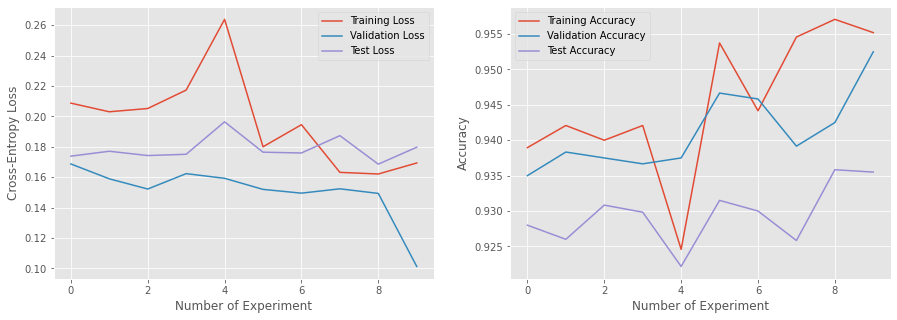

In [84]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ANN Results

Belwo the results for the ANN are generated.

In [85]:
f = pd.get_dummies(features)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)

Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 1.5594 - accuracy: 0.4813 - val_loss: 0.6174 - val_accuracy: 0.6842
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.7149 - val_loss: 0.4511 - val_accuracy: 0.8167
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.5266 - accuracy: 0.8014 - val_loss: 0.3898 - val_accuracy: 0.8533
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.8284 - val_loss: 0.3509 - val_accuracy: 0.8683
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4354 - accuracy: 0.8469 - val_loss: 0.3296 - val_accuracy: 0.8692
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4235 - accuracy: 0.8574 - val_loss: 0.3084 - val_accuracy: 0.8817
Epoch 7/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.8349 - val_loss: 0.2968 - val_accuracy: 0.8883
Epoch 8/400
9

Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2535 - accuracy: 0.9242 - val_loss: 0.1648 - val_accuracy: 0.9275
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2591 - accuracy: 0.9225 - val_loss: 0.1659 - val_accuracy: 0.9317
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2708 - accuracy: 0.9154 - val_loss: 0.1623 - val_accuracy: 0.9375
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2599 - accuracy: 0.9196 - val_loss: 0.1631 - val_accuracy: 0.9383
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2147 - accuracy: 0.9320 - val_loss: 0.1693 - val_accuracy: 0.9283
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2340 - accuracy: 0.9283 - val_loss: 0.1632 - val_accuracy: 0.9350
Epoch 65/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2445 - accuracy: 0.9214 - val_loss: 0.1749 - val_accuracy: 0.9283
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9311 - val_loss: 0.1575 - val_accuracy: 0.9325
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2368 - accuracy: 0.9325 - val_loss: 0.1597 - val_accuracy: 0.9275
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2152 - accuracy: 0.9324 - val_loss: 0.1527 - val_accuracy: 0.9333
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2209 - accuracy: 0.9331 - val_loss: 0.1541 - val_accuracy: 0.9358
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2396 - accuracy: 0.9278 - val_loss: 0.1517 - val_accuracy: 0.9417
Epoch 121/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9192 - val_loss: 0.1648 - val_accuracy: 0.9400
Epoch 122/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2417 - accuracy: 0.9272 - val_loss: 0.1668 - val_accuracy: 0.9333
Epoch 123/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.9337 - val_loss: 0.1513 - val_accuracy: 0.9367
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2061 - accuracy: 0.9331 - val_loss: 0.1686 - val_accuracy: 0.9350
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2596 - accuracy: 0.9311 - val_loss: 0.1523 - val_accuracy: 0.9383
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2328 - accuracy: 0.9316 - val_loss: 0.1499 - val_accuracy: 0.9383
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2171 - accuracy: 0.9303 - val_loss: 0.1515 - val_accuracy: 0.9417
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2278 - accuracy: 0.9338 - val_loss: 0.1509 - val_accuracy: 0.9392
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2295 - accuracy: 0.9323 - val_loss: 0.1514 - val_accuracy: 0.9383
Epoch 180/400

96/96 [==============================] - 0s 5ms/step - loss: 0.9520 - accuracy: 0.7918 - val_loss: 0.2533 - val_accuracy: 0.8958
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.3608 - accuracy: 0.8992 - val_loss: 0.1994 - val_accuracy: 0.9292
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3235 - accuracy: 0.9020 - val_loss: 0.2128 - val_accuracy: 0.9125
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3210 - accuracy: 0.8993 - val_loss: 0.1874 - val_accuracy: 0.9267
Epoch 234/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2823 - accuracy: 0.9103 - val_loss: 0.1879 - val_accuracy: 0.9242
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.9143 - val_loss: 0.1782 - val_accuracy: 0.9300
Epoch 236/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3081 - accuracy: 0.9048 - val_loss: 0.1776 - val_accuracy: 0.9317
Epoch 237/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2235 - accuracy: 0.9330 - val_loss: 0.1504 - val_accuracy: 0.9325
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2099 - accuracy: 0.9393 - val_loss: 0.1526 - val_accuracy: 0.9358
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2020 - accuracy: 0.9325 - val_loss: 0.1565 - val_accuracy: 0.9350
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2272 - accuracy: 0.9329 - val_loss: 0.1508 - val_accuracy: 0.9392
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.9316 - val_loss: 0.1533 - val_accuracy: 0.9325
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2330 - accuracy: 0.9325 - val_loss: 0.1622 - val_accuracy: 0.9383
Epoch 293/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2367 - accuracy: 0.9304 - val_loss: 0.1483 - val_accuracy: 0.9342
Epoch 294/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.9385 - val_loss: 0.1467 - val_accuracy: 0.9367
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2233 - accuracy: 0.9361 - val_loss: 0.1490 - val_accuracy: 0.9383
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.9393 - val_loss: 0.1449 - val_accuracy: 0.9392
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2179 - accuracy: 0.9363 - val_loss: 0.1456 - val_accuracy: 0.9367
Epoch 348/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2343 - accuracy: 0.9305 - val_loss: 0.1473 - val_accuracy: 0.9408
Epoch 349/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2582 - accuracy: 0.9304 - val_loss: 0.1467 - val_accuracy: 0.9350
Epoch 350/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2205 - accuracy: 0.9331 - val_loss: 0.1455 - val_accuracy: 0.9400
Epoch 351/400

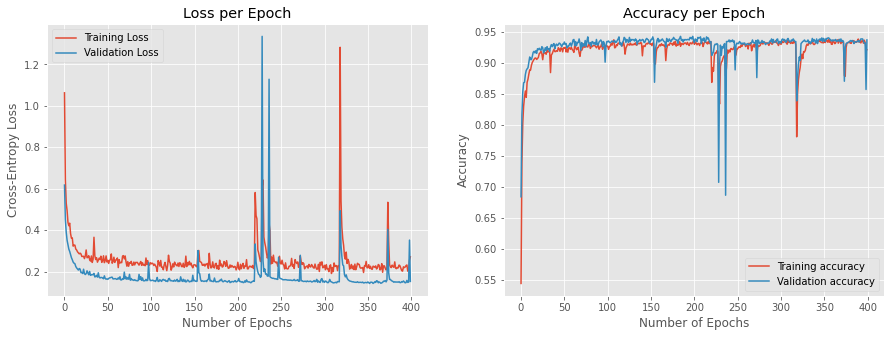

In [86]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [87]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

47/47 [==============================] - 0s 2ms/step - loss: 0.1794 - accuracy: 0.9267
test loss, test acc: [0.17937184870243073, 0.9266666769981384]


In [88]:
results[0]

0.17937184870243073

## Below the results for the Support Vector Machine are Generated

The label is transformed such that unsatisfied or neutral passengers are coded as -1 and satisfied passenger are coded as 1. 

In [89]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9466666666666667
Validation Accuracy:  0.9283333333333333


### Get results for the Test data

In [90]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [91]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

Test Accuracy:  0.9263333333333333
0.9263333333333333


## Results for the Random Forest Classifier

In [92]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-92-658d8ea662f0>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.9425


In [93]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Test Accuracy:  0.944
0.9341434731477851


## Results for AdaBoost

In [94]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9358333333333333
Validation Accuracy:  0.925
Test Accuracy:  0.3878333333333333
0.9134445534838076


## Results for Naive Bayes

In [95]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Training Accuracy:  0.8752083333333334
Validation Accuracy:  0.8708333333333333
Test Accuracy:  0.3511666666666667
0.8318199763126727


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Results for QDA

In [96]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))

Training Accuracy:  0.7079166666666666
Validation Accuracy:  0.6991666666666667
Test Accuracy:  0.17983333333333335


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Results for Logistic Regression

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))

Training Accuracy:  0.878125
Validation Accuracy:  0.8841666666666667
Test Accuracy:  0.8615
0.8359976317347543
